In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.stats import pearsonr, spearmanr
from itertools import product

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [21]:
# --- Paths
OUTDIR = Path('/project/deeprna/data/revision/knockouts')
META_PATH = OUTDIR / 'knockout_metadata.npz'
CIS_PATH = OUTDIR / 'cis_ko_preds.npy'
TRANS_PATH = OUTDIR / 'trans_ko_preds.npy'
WT_PATH = OUTDIR / 'tissue_preds.npy'
MEAN_TF_PATH = OUTDIR / 'mean_tf_preds.npy'
MEAN_BASELINE_PATH = OUTDIR / 'mean_baseline.npy'
GT_PATH = OUTDIR / 'ground_truth.npy'
TFBS_COUNTS_PATH = OUTDIR / 'cis_ko_tfbs_counts.npy'
TFBS_COORDS_PATH = OUTDIR / 'cis_ko_tfbs_coords.npy'
REGIONS_BED = Path('/project/deeprna/data/revision/insilico_ko_selected_regions.bed')
GTF_PATH = Path('/project/deeprna/benchmark/exons.gtf')
BIN_SIZE = 64
CROP_BINS = 1024
TARGET_BINS = 6144

In [22]:
# Load metadata
meta = np.load(META_PATH, allow_pickle=True)
tissues = meta['tissues'].tolist()
region_ids = meta['region_ids'].astype(int)
tf_list = meta['tfs'].tolist()
channels = meta['channels'].tolist()

# Load outputs
cis = np.load(CIS_PATH, mmap_mode='r')
trans = np.load(TRANS_PATH, mmap_mode='r')
wt = np.load(WT_PATH, mmap_mode='r')
mean_tf = np.load(MEAN_TF_PATH, mmap_mode='r')
mean_baseline = np.load(MEAN_BASELINE_PATH, mmap_mode='r')
gt = np.load(GT_PATH, mmap_mode='r')
tfbs_counts = np.load(TFBS_COUNTS_PATH)
tfbs_coords = np.load(TFBS_COORDS_PATH, allow_pickle=True)

print('cis', cis.shape)
print('trans', trans.shape)
print('wt', wt.shape)
print('mean_tf', mean_tf.shape)
print('mean_baseline', mean_baseline.shape)
print('gt', gt.shape)
print('tfbs_counts', tfbs_counts.shape)
print('tfbs_coords', tfbs_coords.shape)

TRACKS_PLOT = ['dnase','h3k4me3','h3k27ac']
TRACKS_GLOBAL = ['dnase','h3k4me3','h3k27ac']
track_idx = [channels.index(x) for x in TRACKS_PLOT]
global_idx = [channels.index(x) for x in TRACKS_GLOBAL]
track_idx, global_idx

cis (5, 50, 64, 6144, 14)
trans (5, 50, 64, 6144, 14)
wt (5, 50, 6144, 14)
mean_tf (50, 6144, 14)
mean_baseline (50, 6144, 14)
gt (5, 50, 6144, 14)
tfbs_counts (50, 64)
tfbs_coords (50, 64)


([0, 3, 6], [0, 3, 6])

In [23]:
# Add RNA and CAGE tracks (sum of strands)
channels.extend(['rna', 'cage'])

cis = np.concatenate([cis, cis[:, :, :, :, [10, 11]].sum(axis=4, keepdims=True)], axis=4)
trans = np.concatenate([trans, trans[:, :, :, :, [10, 11]].sum(axis=4, keepdims=True)], axis=4)
wt = np.concatenate([wt, wt[:, :, :, [10, 11]].sum(axis=3, keepdims=True)], axis=3)
mean_tf = np.concatenate([mean_tf, mean_tf[:, :,[10, 11]].sum(axis=2, keepdims=True)], axis=2)
mean_baseline = np.concatenate([mean_baseline, mean_baseline[:, :, [10, 11]].sum(axis=2, keepdims=True)], axis=2)
gt = np.concatenate([gt, gt[:, :, :, [10, 11]].sum(axis=3, keepdims=True)], axis=3)

cis = np.concatenate([cis, cis[:, :, :, :, [12, 13]].sum(axis=4, keepdims=True)], axis=4)
trans = np.concatenate([trans, trans[:, :, :, :, [12, 13]].sum(axis=4, keepdims=True)], axis=4)
wt = np.concatenate([wt, wt[:, :, :, [12, 13]].sum(axis=3, keepdims=True)], axis=3)
mean_tf = np.concatenate([mean_tf, mean_tf[:, :, [12, 13]].sum(axis=2, keepdims=True)], axis=2)
mean_baseline = np.concatenate([mean_baseline, mean_baseline[:, :, [12, 13]].sum(axis=2, keepdims=True)], axis=2)
gt = np.concatenate([gt, gt[:, :, :, [12, 13]].sum(axis=3, keepdims=True)], axis=3)

print('cis', cis.shape)

cis (5, 50, 64, 6144, 16)


In [24]:
print(channels)

['dnase', 'h3k4me1', 'h3k4me2', 'h3k4me3', 'h3k9ac', 'h3k9me3', 'h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k79me2', 'rna_total_plus', 'rna_total_minus', 'cage_plus', 'cage_minus', 'rna', 'cage']


In [25]:
signal_amplifier = 10
cis_delta = cis - wt[:, :, None, :, :]  # (tissues, regions, tfs, bins, channels)
trans_delta = trans - wt[:, :, None, :, :]
cis_amp = wt[:, :, None, :, :] + signal_amplifier * cis_delta
trans_amp = wt[:, :, None, :, :] + signal_amplifier * trans_delta

In [26]:
cis_logfc = np.log2(cis + 1) - np.log2(wt[:, :, None, :, :] + 1)
trans_logfc = np.log2(trans + 1) - np.log2(wt[:, :, None, :, :] + 1)

In [27]:
regions = pd.read_csv(REGIONS_BED, sep='\t', header=None, names=['chrom','start','end','region_id'])
regions = regions.set_index('region_id').loc[region_ids].reset_index()

In [9]:
tissue_tfs = {46: ['HDX',
  'EWSR1',
  'SOX30',
  'GMEB1',
  'HIC2',
  'LHX4',
  'ZNF625',
  'ZNF232',
  'ZNF93',
  'ZNF730',
  'ZNF813',
  'ZNF114',
  'ZNF670',
  'E2F1',
  'GATAD2A',
  'ZNF644',
  'POU5F1',
  'THAP11',
  'YBX1',
  'CREB1',
  'ZBTB44'],
 105: ['ZNF628',
  'HOXB3',
  'MESP2',
  'HIC2',
  'TBX20',
  'FOXR1',
  'ZNF627',
  'ZNF625',
  'ZNF232',
  'ZNF93',
  'ZNF730',
  'ZNF114',
  'ZNF629',
  'E2F1',
  'ID2',
  'MEF2A',
  'SRF',
  'THAP11',
  'NRL',
  'YBX1',
  'ZNF821',
  'ZSCAN1',
  'MZF1',
  'ZNF362'],
 276: ['HNF1B', 'NR1H3', 'FOXA1', 'FOXA2', 'NR1I3'],
 239: ['HDX',
  'EWSR1',
  'GMEB1',
  'HIC2',
  'BCLAF1',
  'ZNF235',
  'ZNF627',
  'ZNF625',
  'ZNF711',
  'ZNF232',
  'ZFP69B',
  'ZNF117',
  'ZNF93',
  'ZNF284',
  'ZNF730',
  'ZNF813',
  'ZNF557',
  'ZNF114',
  'ZNF670',
  'ZNF559',
  'ZNF226',
  'ZNF629',
  'ZBTB11',
  'ATF2',
  'ZNF644',
  'HNRNPUL1',
  'DPF2',
  'POU5F1',
  'ZNF549',
  'ZNF816',
  'ZNF595',
  'CLOCK',
  'YBX1',
  'ZNF821',
  'ZSCAN1',
  'ZNF16',
  'CREB1',
  'RBAK'],
 323: ['ZNF628',
  'MESP2',
  'SOX30',
  'HIC2',
  'LHX4',
  'FOXR1',
  'ZNF705G',
  'ZNF556',
  'ZNF711',
  'ZNF117',
  'GATAD2A',
  'KLF14',
  'ZNF595',
  'ZSCAN1',
  'OVOL1']}

In [10]:
from collections import defaultdict
tf_to_tissue = defaultdict(list)
for tissue_idx, tf_names in tissue_tfs.items():
    for tf in tf_names:
        tf_to_tissue[tf].append(tissue_idx)

In [11]:
# Verify that the dictionary is correct (should have 64 total TFs)
len(set([tf for tfs in tissue_tfs.values() for tf in tfs]))

64

## Cis-trans relationships

In [12]:
tf_tissue_pairs = [
    (46, 'SOX30'),
    (46, 'E2F1'), 
    (46, 'POU5F1'),
    (46, 'THAP11'),
    (46, 'CREB1'),
    (105, 'MESP2'),
    (105, 'HIC2'), 
    (105, 'TBX20'),
    (105, 'MEF2A'),
    (105, 'SRF'),
    (276, 'HNF1B'),
    (276, 'NR1H3'),
    (276, 'NR1I3'),
    (276, 'FOXA1'),
    (276, 'FOXA2'),
    (239, 'GMEB1'),
    (239, 'ZNF670'),
    (239, 'ZNF711'),
    (239, 'ATF2'),
    (239, 'DPF2'),
    (323, 'OVOL1'),
    (323, 'ZNF595'),
    (323, 'FOXR1'),
    (323, 'LHX4'),
    (323, 'KLF14'),
]

In [13]:
tissue_names = {46: 'iPSC', 105: 'Cardiac myocyte', 276: 'Liver', 239: 'Neural progenitor', 323: 'Testis'}

/scratch/local/ipykernel_82855/2306810110.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(c, t)
/scratch/local/ipykernel_82855/2306810110.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(c, t)


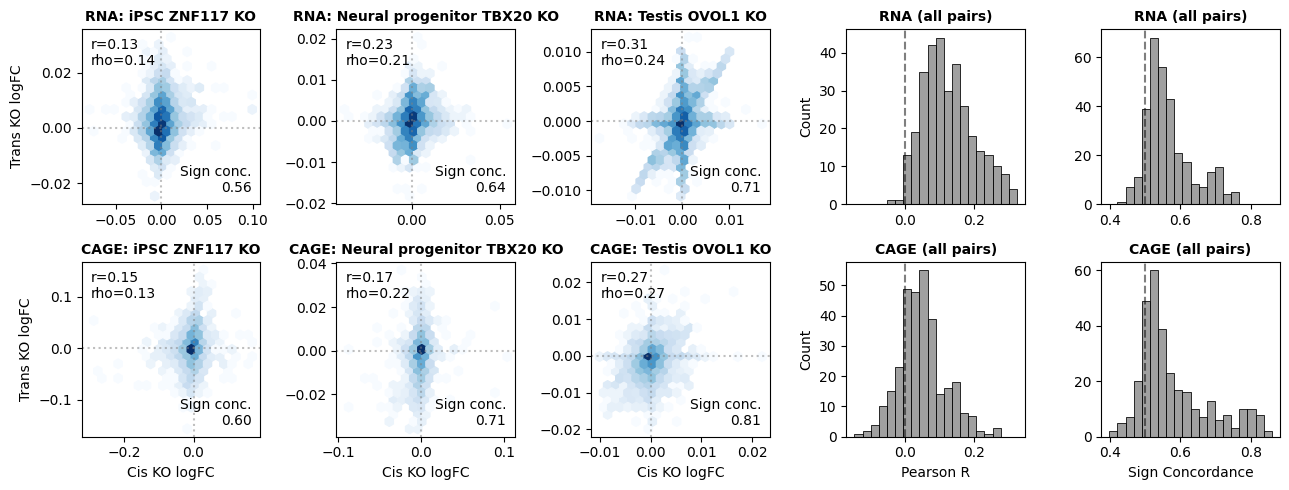

In [97]:
# Plot hexbins for rna (top) and cage (bottom), for selected TF-tissue pairs
# One TF per column, 3 columns. Then pearson R histogram, and sign conc. histogram. 5 cols in total

plot_tf_tissue_pairs = [
    (239, 'TBX20'),
    (46, 'ZNF117'),
    (323, 'OVOL1')
]

r_values = [[], []]
sign_values = [[], []]

j = 0
fig, axes = plt.subplots(2, 5, figsize=(13, 5))
for tissue, tf in product(tissues, tf_list):
    for i, channel in enumerate([14, 15]):  # RNA, CAGE
        tissue_idx = tissues.index(tissue)
        tf_idx = tf_list.index(tf)

        c = cis_logfc[tissue_idx, :, tf_idx, :, channel].flatten()
        t = trans_logfc[tissue_idx, :, tf_idx, :, channel].flatten()

        nonzero_mask = (np.isclose(c, 0) == False) & (np.isclose(t, 0) == False)
        cis_signs = np.sign(c[nonzero_mask])
        trans_signs = np.sign(t[nonzero_mask])
        sign_concordance = (cis_signs == trans_signs).sum() / len(cis_signs) if len(cis_signs) > 0 else np.nan
        sign_values[i].append(sign_concordance)

        r, p = pearsonr(c, t)
        rho, _ = spearmanr(c, t)
        r_values[i].append(r)
        if (tissue, tf) in plot_tf_tissue_pairs:
            ax = axes[i, j]
            ax.hexbin(x=c, y=t, gridsize=20, cmap='Blues', mincnt=1, bins='log')
            ax.set_title(f'{channels[channel].upper()}: {tissue_names[tissue]} {tf} KO', fontsize=10, weight='bold')
            ax.text(0.05, 0.95, f'r={r:.2f}\nrho={rho:.2f}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.95, 0.05, f'Sign conc.\n{sign_concordance:.2f}', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right')
            ax.axvline(0, color='gray', linestyle='dotted', alpha=0.5)
            ax.axhline(0, color='gray', linestyle='dotted', alpha=0.5)
            if i == 1:
                j += 1

# Histogram bins should be same for both rows
histo_r = np.linspace(min(min(r_values[0]), min(r_values[1])), max(max(r_values[0]), max(r_values[1])), 21)
histo_sign = np.linspace(min(min(sign_values[0]), min(sign_values[1])), max(max(sign_values[0]), max(sign_values[1])), 21)
# Pearson R histograms
for i in range(2):
    ax = axes[i, 3]
    sns.histplot(r_values[i], bins=histo_r, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('RNA (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('CAGE (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

# Sign concordance histograms
for i in range(2):
    ax = axes[i, 4]
    sns.histplot(sign_values[i], bins=histo_sign, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('RNA (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('CAGE (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel('')

for i in range(2):
    axes[i, 0].set_ylabel('Trans KO logFC')
for i in range(3):
    axes[1, i].set_xlabel('Cis KO logFC')

# axes[0, 3].set_ylabel('Count')
# axes[1, 3].set_ylabel('Count')
axes[1, 3].set_xlabel('Pearson R')
axes[1, 4].set_xlabel('Sign Concordance')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig6b.pdf', dpi=300)

/scratch/local/ipykernel_82855/1016398258.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(c, t)
/scratch/local/ipykernel_82855/1016398258.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(c, t)


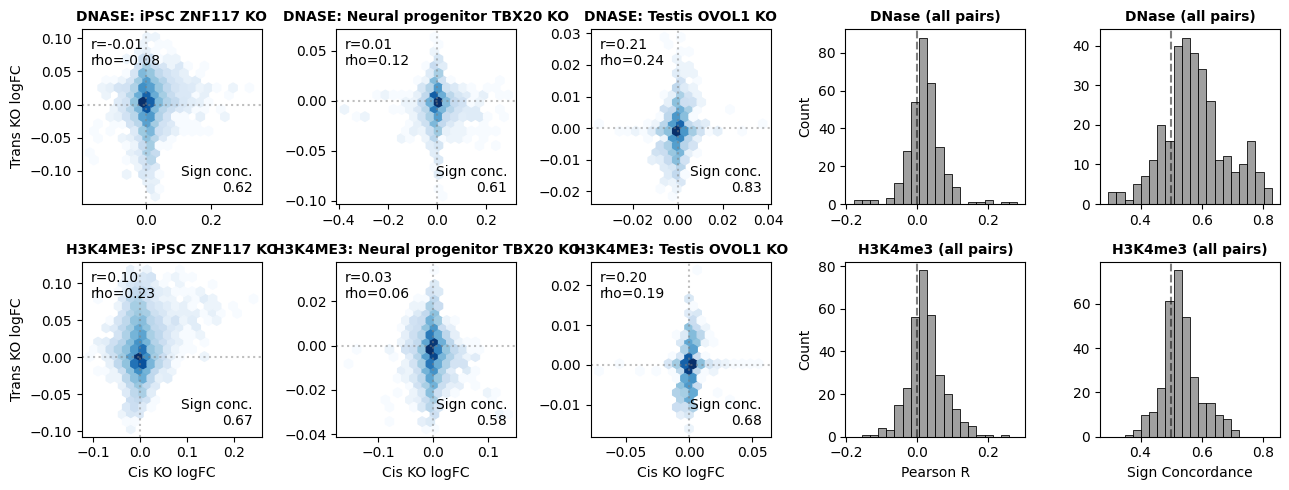

In [99]:
# Plot hexbins for rna (top) and cage (bottom), for selected TF-tissue pairs
# One TF per column, 3 columns. Then pearson R histogram, and sign conc. histogram. 5 cols in total

plot_tf_tissue_pairs = [
    (239, 'TBX20'),
    (46, 'ZNF117'),
    (323, 'OVOL1')
]

r_values = [[], []]
sign_values = [[], []]

j = 0
fig, axes = plt.subplots(2, 5, figsize=(13, 5))
for tissue, tf in product(tissues, tf_list):
    for i, channel in enumerate([0, 3]):  # dnase, h3k4me3
        tissue_idx = tissues.index(tissue)
        tf_idx = tf_list.index(tf)

        c = cis_logfc[tissue_idx, :, tf_idx, :, channel].flatten()
        t = trans_logfc[tissue_idx, :, tf_idx, :, channel].flatten()

        nonzero_mask = (np.isclose(c, 0) == False) & (np.isclose(t, 0) == False)
        cis_signs = np.sign(c[nonzero_mask])
        trans_signs = np.sign(t[nonzero_mask])
        sign_concordance = (cis_signs == trans_signs).sum() / len(cis_signs) if len(cis_signs) > 0 else np.nan
        sign_values[i].append(sign_concordance)

        r, p = pearsonr(c, t)
        rho, _ = spearmanr(c, t)
        r_values[i].append(r)
        if (tissue, tf) in plot_tf_tissue_pairs:
            ax = axes[i, j]
            ax.hexbin(x=c, y=t, gridsize=20, cmap='Blues', mincnt=1, bins='log')
            ax.set_title(f'{channels[channel].upper()}: {tissue_names[tissue]} {tf} KO', fontsize=10, weight='bold')
            ax.text(0.05, 0.95, f'r={r:.2f}\nrho={rho:.2f}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.95, 0.05, f'Sign conc.\n{sign_concordance:.2f}', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right')
            ax.axvline(0, color='gray', linestyle='dotted', alpha=0.5)
            ax.axhline(0, color='gray', linestyle='dotted', alpha=0.5)
            if i == 1:
                j += 1

# Histogram bins should be same for both rows
histo_r = np.linspace(min(min(r_values[0]), min(r_values[1])), max(max(r_values[0]), max(r_values[1])), 21)
histo_sign = np.linspace(min(min(sign_values[0]), min(sign_values[1])), max(max(sign_values[0]), max(sign_values[1])), 21)
# Pearson R histograms
for i in range(2):
    ax = axes[i, 3]
    sns.histplot(r_values[i], bins=histo_r, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('DNase (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('H3K4me3 (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

# Sign concordance histograms
for i in range(2):
    ax = axes[i, 4]
    sns.histplot(sign_values[i], bins=histo_sign, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('DNase (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('H3K4me3 (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel('')

for i in range(2):
    axes[i, 0].set_ylabel('Trans KO logFC')
for i in range(3):
    axes[1, i].set_xlabel('Cis KO logFC')

# axes[0, 3].set_ylabel('Count')
# axes[1, 3].set_ylabel('Count')
axes[1, 3].set_xlabel('Pearson R')
axes[1, 4].set_xlabel('Sign Concordance')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig6_supplement.pdf', dpi=300)

## Fig. 6c

In [50]:
# --- Fig. 6c helpers + plot function
ENSEMBL_REST = "https://rest.ensembl.org"

def fetch_overlap_genes(chrom, start, end):
    region = f"{chrom}:{start}-{end}"
    url = f"{ENSEMBL_REST}/overlap/region/human/{region}?feature=gene"
    headers = {"Content-Type": "application/json"}
    resp = requests.get(url, headers=headers, timeout=30)
    if not resp.ok:
        return []
    return resp.json()

def fetch_nearest_genes(chrom, start, end):
    mid = (start + end) // 2
    url = f"{ENSEMBL_REST}/overlap/region/human/{chrom}:{mid}-{mid}?feature=gene"
    headers = {"Content-Type": "application/json"}
    resp = requests.get(url, headers=headers, timeout=30)
    if not resp.ok:
        return []
    return resp.json()

def gene_context(chrom, start, end):
    genes = fetch_overlap_genes(chrom, start, end)
    if genes:
        names = sorted({g.get('external_name', g.get('id', 'NA')) for g in genes})
        return f"Genes: {', '.join(names[:6])}"
    near = fetch_nearest_genes(chrom, start, end)
    if not near:
        return "Intergenic"
    names = sorted({g.get('external_name', g.get('id', 'NA')) for g in near})
    return f"Intergenic (nearest: {', '.join(names[:4])})"

def locus_bins(region_row):
    chrom = region_row['chrom']
    start = int(region_row['start'])
    central_start = start + CROP_BINS * BIN_SIZE
    central_end = central_start + TARGET_BINS * BIN_SIZE
    bin_starts = central_start + np.arange(TARGET_BINS) * BIN_SIZE
    bin_ends = bin_starts + BIN_SIZE
    return chrom, central_start, central_end, bin_starts, bin_ends

def mean_pool_bins(x, k=4):
    bins = x.shape[-1]
    trim = bins - (bins % k)
    if trim == 0:
        raise ValueError("Not enough bins to pool.")
    x_trim = x[..., :trim]
    new_shape = x_trim.shape[:-1] + (trim // k, k)
    return x_trim.reshape(new_shape).mean(axis=-1)

def _step_arrays(x, y, width):
    x_left = x
    x_right = x + width
    x_step = np.repeat(np.column_stack([x_left, x_right]), 1, axis=0).reshape(-1)
    y_step = np.repeat(y, 2)
    return x_step, y_step

def plot_ko_region_for_tf_tissue(
    tissue_id,
    tf_name,
    channel='rna',
    plot_size=50_000,
    row_height=1.4,
    use_logfc_for_center=False,
    delta_amplifier=1.0,
    plot_resolution=64,
    bar_alpha=0.6,
    diff_alpha=0.4,
    topk=1,
    change_direction='both',
    ko='cis',
):
    tissue_idx = tissues.index(tissue_id)
    tf_idx = tf_list.index(tf_name)
    ch_idx = channels.index(channel)
    row_height = float(row_height)
    delta_amplifier = float(delta_amplifier)
    plot_resolution = int(plot_resolution)
    if plot_resolution % BIN_SIZE != 0:
        raise ValueError(f"plot_resolution must be a multiple of {BIN_SIZE}")
    k_plot = plot_resolution // BIN_SIZE
    topk = max(1, int(topk))
    if change_direction not in {'both', 'pos', 'neg'}:
        raise ValueError("change_direction must be one of {'both','pos','neg'}")
    if ko not in {'cis', 'trans'}:
        raise ValueError("ko must be one of {'cis','trans'}")

    wt_t = wt[tissue_idx]  # (regions, bins, channels)
    cis_t = cis[tissue_idx, :, tf_idx]
    trans_t = trans[tissue_idx, :, tf_idx]

    if use_logfc_for_center:
        cis_metric = cis_logfc[tissue_idx, :, tf_idx, :, ch_idx]
        trans_metric = trans_logfc[tissue_idx, :, tf_idx, :, ch_idx]
    else:
        cis_metric = cis_t[:, :, ch_idx] - wt_t[:, :, ch_idx]
        trans_metric = trans_t[:, :, ch_idx] - wt_t[:, :, ch_idx]

    # Mean-pool to 256 bp resolution (k=4) for max-change bin selection
    cis_pool = mean_pool_bins(cis_metric, k=4)
    trans_pool = mean_pool_bins(trans_metric, k=4)
    metric_pool = cis_pool if ko == 'cis' else trans_pool
    if change_direction == 'both':
        score_pool = np.abs(metric_pool)
    elif change_direction == 'pos':
        score_pool = np.where(metric_pool > 0, metric_pool, -np.inf)
    else:
        score_pool = np.where(metric_pool < 0, -metric_pool, -np.inf)

    # pick top regions based on their best pooled bin score (unique regions)
    best_bin_idx = np.nanargmax(score_pool, axis=1)
    best_scores = score_pool[np.arange(score_pool.shape[0]), best_bin_idx]
    best_scores = np.where(np.isfinite(best_scores), best_scores, -np.inf)
    region_order = np.argsort(best_scores)[::-1]
    region_order = region_order[:topk]
    top_regions = [(int(r), int(best_bin_idx[r]), float(best_scores[r])) for r in region_order]

    def slice_and_pool(y, bin_start, bin_end):
        y_slice = y[bin_start:bin_end]
        if k_plot > 1:
            y_slice = y_slice.reshape(-1, k_plot).mean(axis=1)
        return y_slice

    for rank, (region_idx, pooled_bin_idx, score_val) in enumerate(top_regions, start=1):
        center_bin = pooled_bin_idx * 4 + 2  # middle of 4 bins
        window_bins = int(plot_size // BIN_SIZE)
        window_bins -= (window_bins % k_plot)
        if window_bins == 0:
            window_bins = k_plot
        half = window_bins // 2
        bin_start = max(0, center_bin - half)
        bin_end = min(TARGET_BINS, center_bin + half)
        if (bin_end - bin_start) < window_bins:
            bin_start = max(0, bin_end - window_bins)
            bin_end = min(TARGET_BINS, bin_start + window_bins)
        # ensure window length multiple of k_plot
        window_len = bin_end - bin_start
        if window_len % k_plot != 0:
            bin_end = bin_start + (window_len - (window_len % k_plot))

        row = regions.iloc[region_idx]
        chrom, _, _, bin_starts, _ = locus_bins(row)
        x_full = bin_starts[bin_start:bin_end]
        if k_plot > 1:
            x = x_full.reshape(-1, k_plot)[:, 0]
        else:
            x = x_full

        wt_r = wt_t[region_idx]
        cis_r = cis_t[region_idx]
        trans_r = trans_t[region_idx]
        base_r = mean_baseline[region_idx]
        gt_r = gt[tissue_idx, region_idx]
        motif_positions = tfbs_coords[region_idx, tf_idx]

        entries = [
            {'name': f'{channel} baseline', 'y': base_r[:, ch_idx], 'color': '#9e9e9e', 'kind': 'simple'},
        ]
        if np.any(np.isfinite(gt_r[:, ch_idx])):
            entries.append({'name': f'{channel} ground truth', 'y': gt_r[:, ch_idx], 'color': '#000000', 'kind': 'simple'})
        entries.extend([
            {'name': f'{channel} WT', 'y': wt_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'simple'},
            {'name': f'{channel} trans KO', 'y': trans_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'ko', 'wt': wt_r[:, ch_idx]},
            {'name': f'{channel} cis KO', 'y': cis_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'ko', 'wt': wt_r[:, ch_idx]},
        ])

        # Shared y-limit for signal rows (use plotted values)
        y_max = 0
        for entry in entries:
            y = slice_and_pool(entry['y'], bin_start, bin_end)
            if entry.get('kind') == 'ko':
                wt_y = slice_and_pool(entry['wt'], bin_start, bin_end)
                delta = y - wt_y
                y = wt_y + delta_amplifier * delta
            y_max = max(y_max, np.nanmax(y))
        if not np.isfinite(y_max) or y_max <= 0:
            y_max = 1e-6
        y_lim = (0, y_max * 1.02)

        height_ratios = [1] * len(entries) + [0.25, 0.25]
        fig, axes = plt.subplots(
            len(entries) + 2,
            1,
            figsize=(16, row_height * len(entries) + 1.1),
            sharex=True,
            gridspec_kw={'height_ratios': height_ratios},
        )

        for i, entry in enumerate(entries):
            y = slice_and_pool(entry['y'], bin_start, bin_end)
            color = entry.get('color', 'blue')
            if entry.get('kind') == 'ko':
                wt_y = slice_and_pool(entry['wt'], bin_start, bin_end)
                delta = y - wt_y
                y_plot = wt_y + delta_amplifier * delta
                y_plot = np.clip(y_plot, a_min=0, a_max=None)
                axes[i].bar(x, y_plot, width=plot_resolution, align='edge', color=color, alpha=bar_alpha, linewidth=0, fill=True)
                # Highlight differences relative to WT (aligned to bar edges)
                x_step, y_plot_step = _step_arrays(x, y_plot, plot_resolution)
                _, wt_step = _step_arrays(x, wt_y, plot_resolution)
                dec = y_plot_step < wt_step
                inc = y_plot_step > wt_step
                if np.any(dec):
                    axes[i].fill_between(
                        x_step,
                        y_plot_step,
                        wt_step,
                        where=dec,
                        color='red',
                        alpha=diff_alpha,
                        linewidth=0,
                        antialiased=False,
                    )
                if np.any(inc):
                    axes[i].fill_between(
                        x_step,
                        wt_step,
                        y_plot_step,
                        where=inc,
                        color='green',
                        alpha=diff_alpha,
                        linewidth=0,
                        antialiased=False,
                    )
            else:
                axes[i].bar(x, y, width=plot_resolution, align='edge', color=color, alpha=bar_alpha, linewidth=0)
            axes[i].set_ylabel(entry['name'])
            axes[i].set_ylim(*y_lim)
            axes[i].spines[['top','right']].set_visible(False)
            axes[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

        ax_motif = axes[-2]
        ax_motif.set_ylim(0, 1)
        ax_motif.set_yticks([])
        ax_motif.set_ylabel('TFBS')
        ax_motif.spines[['top','right']].set_visible(False)
        ax_motif.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        if motif_positions is not None and len(motif_positions) > 0:
            motif_positions = np.asarray(motif_positions)
            motif_x = motif_positions[:, 0] + int(row['start'])
            in_window = (motif_x >= x_full[0]) & (motif_x <= x_full[-1])
            motif_x = motif_x[in_window]
            if motif_x.size > 0:
                ax_motif.vlines(motif_x, 0, 1, color='black', linewidth=0.5)

        ax_tx = axes[-1]
        context = gene_context(chrom, int(x_full[0]), int(x_full[-1]))
        ax_tx.text(0.01, 0.4, context, transform=ax_tx.transAxes)
        ax_tx.set_ylim(0, 1)
        ax_tx.set_yticks([])
        ax_tx.set_ylabel('Gene')
        ax_tx.spines[['top','right']].set_visible(False)
        ax_tx.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax_tx.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v):,}"))

        tissue_label = tissue_names.get(tissue_id, str(tissue_id)) if 'tissue_names' in globals() else str(tissue_id)
        title = (
            f'{tissue_label} | TF {tf_name} | {channel.upper()} | '
            f'{ko.upper()} {change_direction} | rank {rank}/{topk} | '
            f'region {row["chrom"]}:{row["start"]}-{row["end"]} | '
            f'center bin {center_bin} (256bp pooled bin {pooled_bin_idx})'
        )
        fig.suptitle(title)
        ax_tx.set_xlabel(f'{chrom}:{int(x_full[0]):,}-{int(x_full[-1]):,}')
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_ko_region_for_tf_tissue(239, 'TBX20', channel='rna', plot_size=50_000, topk=3, change_direction='both', ko='cis')

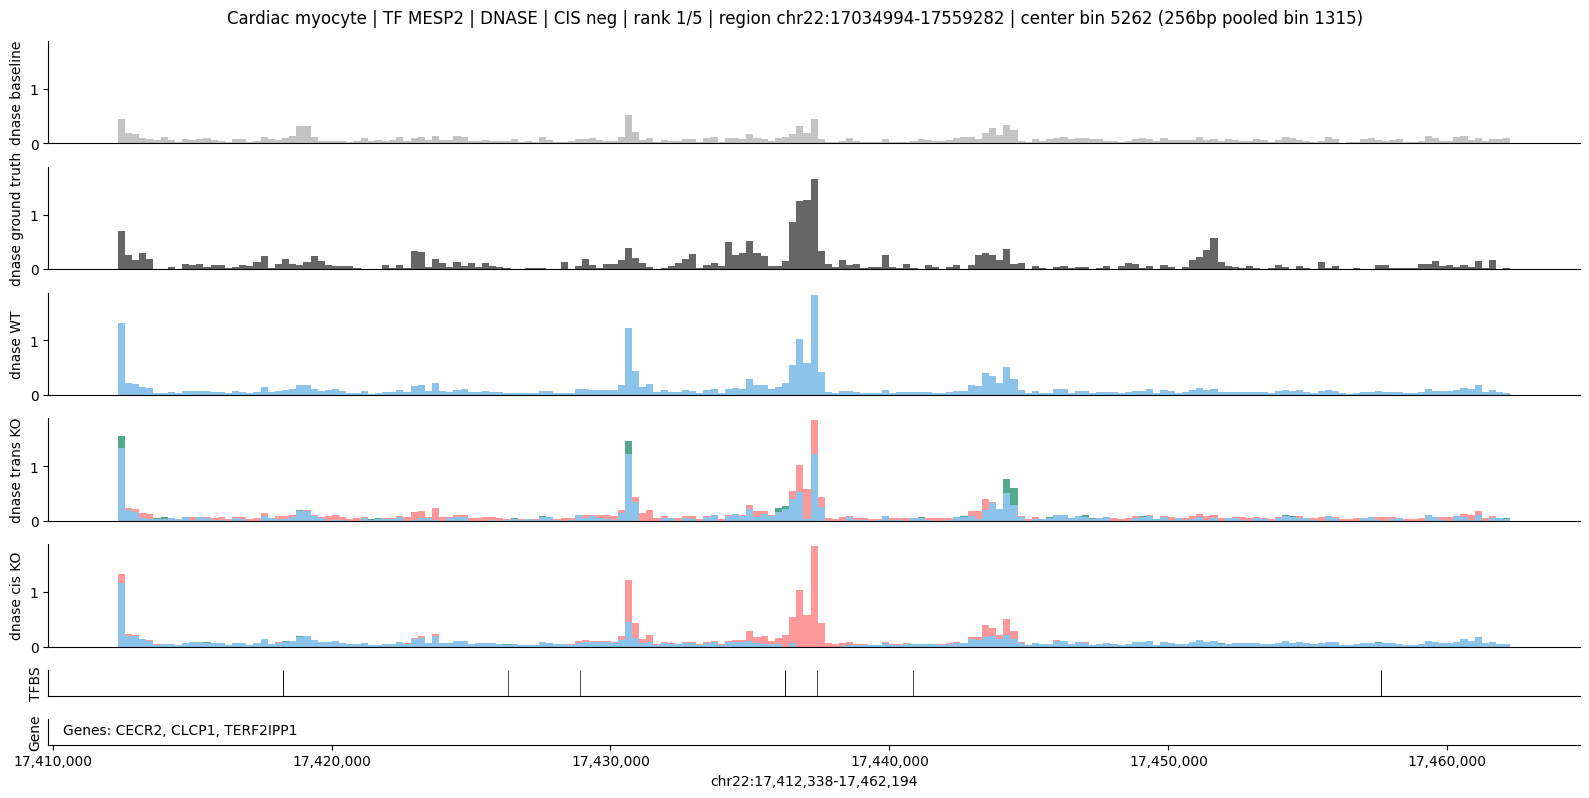

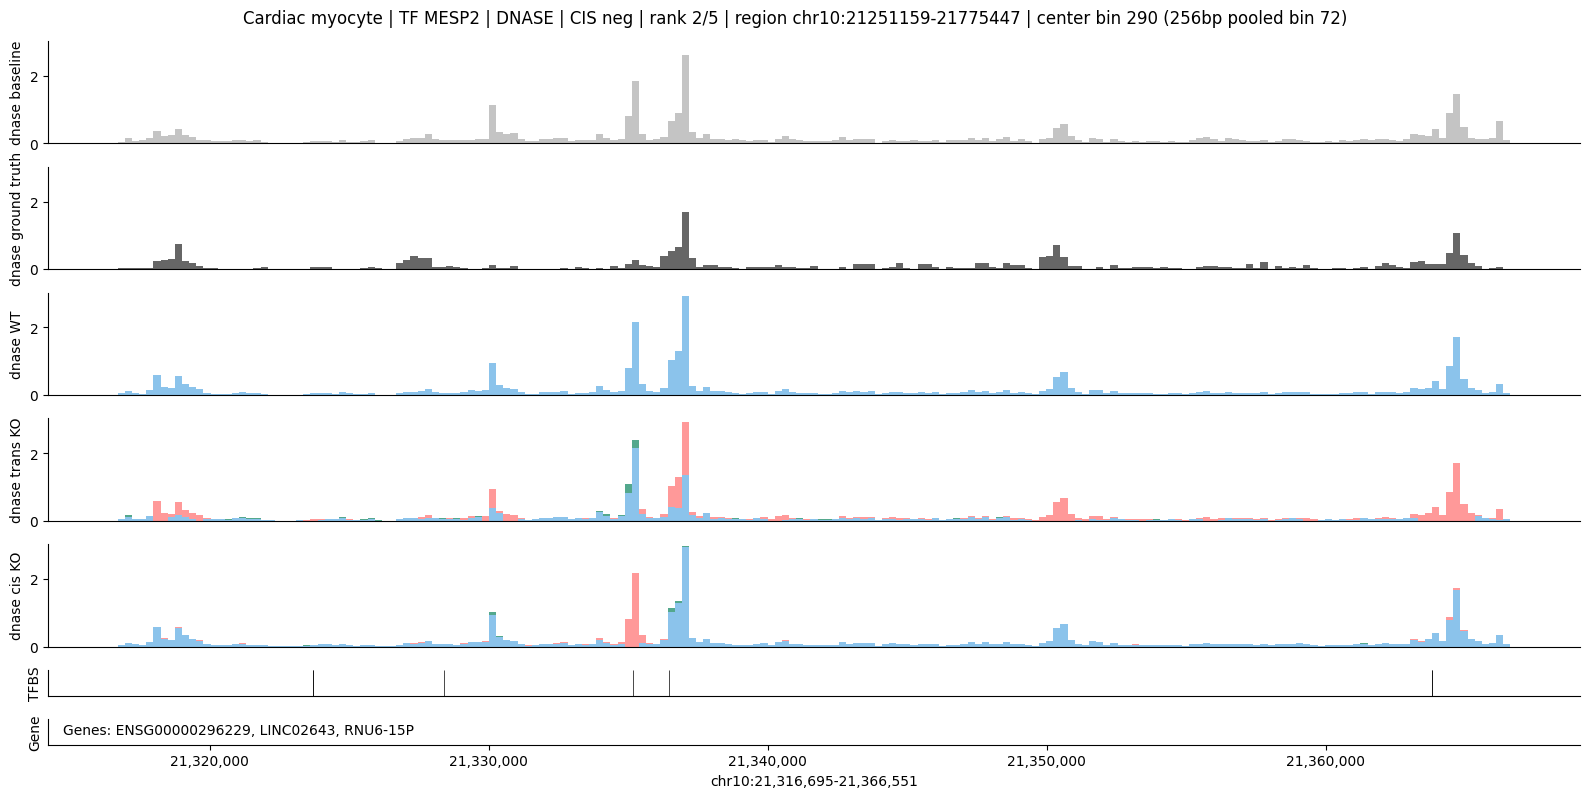

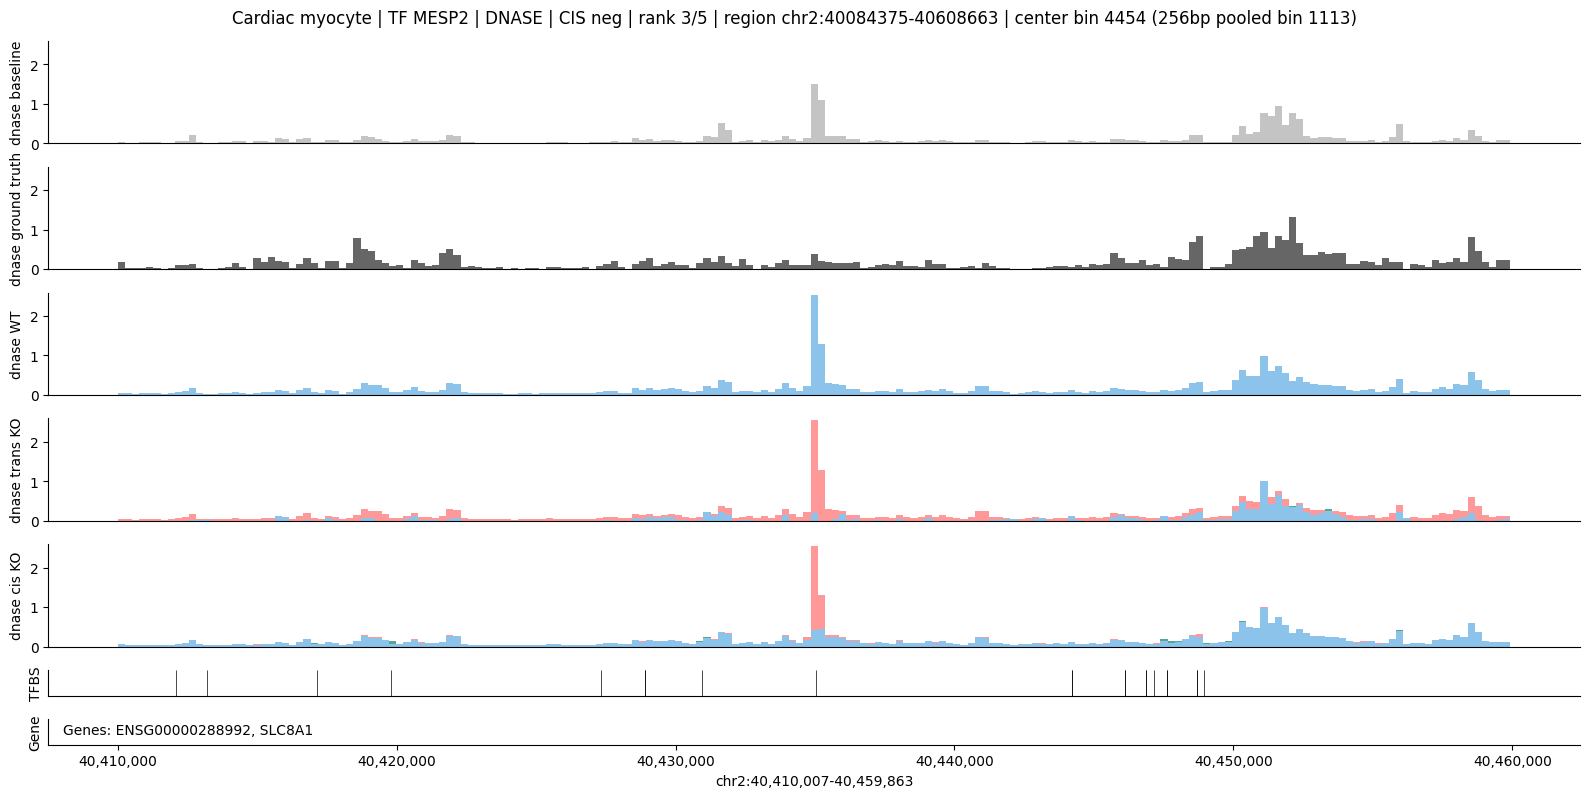

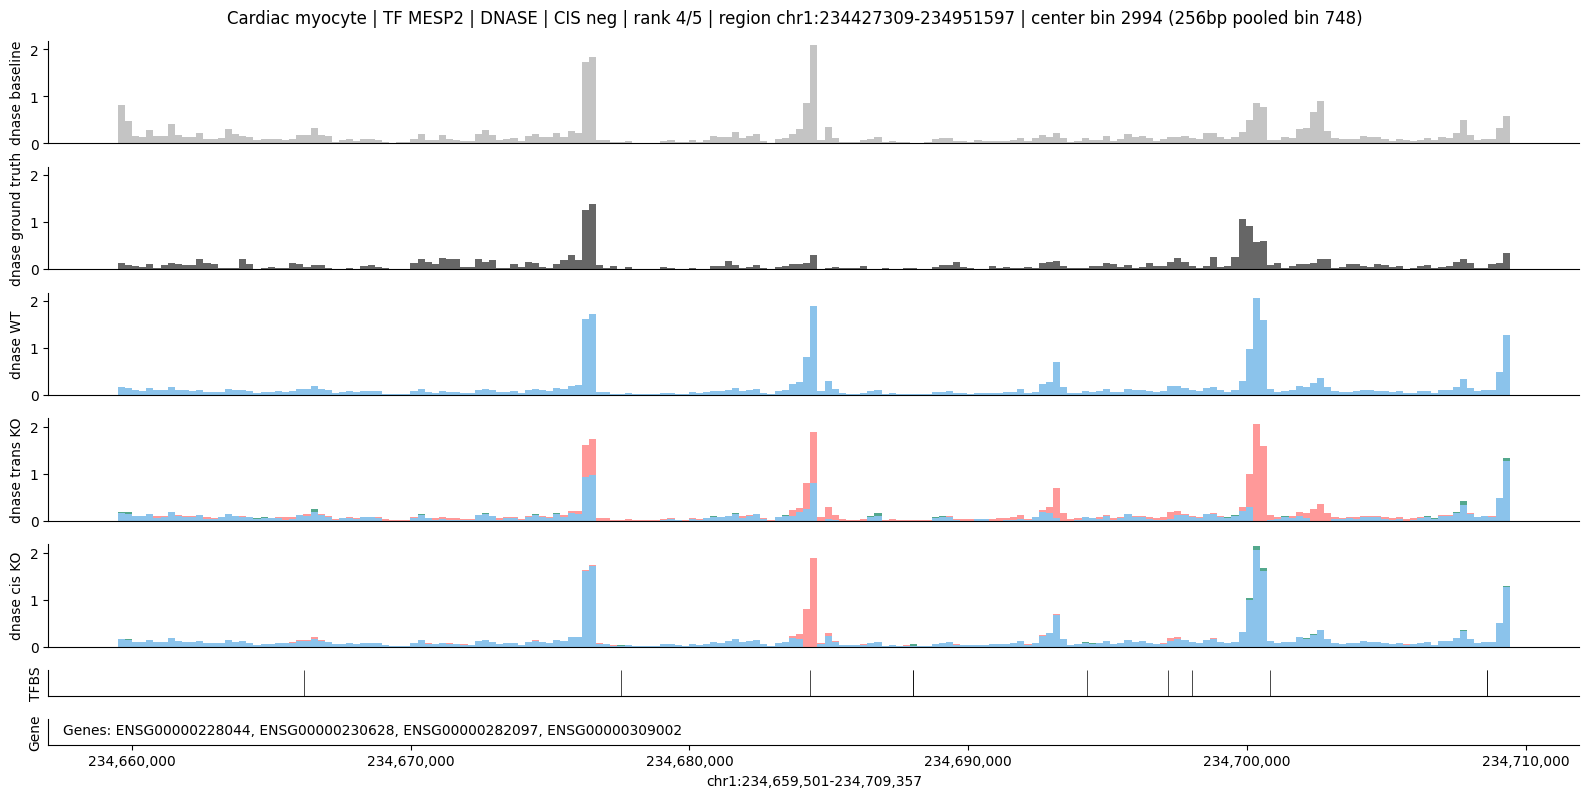

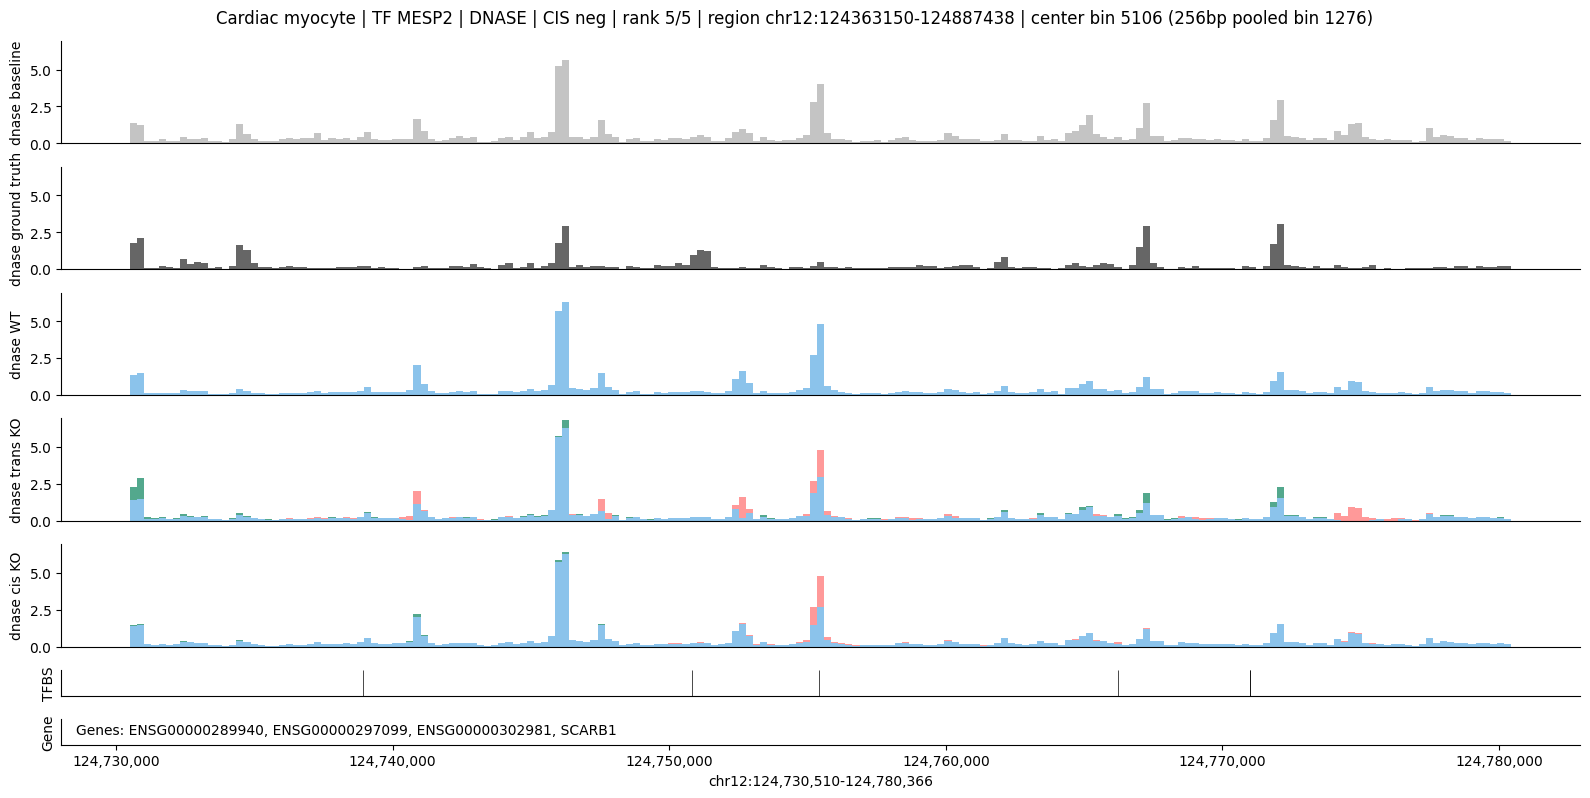

In [76]:
plot_ko_region_for_tf_tissue(105, 'MESP2', channel='dnase', ko='cis', topk=5, change_direction='neg', plot_size=50_000, use_logfc_for_center=False, delta_amplifier=10, plot_resolution=256)